# Charon4 txt to Python
This script loads the data exported with charon4. The following screenshot shows the expected settings while exporting.

2018 data are exported processed different, see `charon4_txt_to_python_2018data.ipynb`

<img src=".\pictures\Charon4_export_window_txt.png" alt="drawing" width="500"/>

The results of this script are stored in `..\Alsdorf\Daten\my_database`. The goal of this database is to contain all data in an easy to read format.

In [1]:
version="v1_2"
# Changelog
#v1_0: has a nice overviwe at the end
#v1_1: add temp data from daniel to data_2019; length are int now; added seperate import for 2018
#v1_2: seperated this notebook into different ones; outsourced some user-defined functions

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import date, timedelta
from collections import defaultdict
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates

# import my User defined functions
from my_func_mvw.functions import get_abspath, all_days_of_year, calculate_measurements_per_day, improve_n_meas_pday

In [30]:
# Input
#path to working directory
#mit \[-]\ im Pfad funktioniert die get_abspath Funktion nicht
path_to_controller=r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt"
path_to_controller_1=r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt\07062021"
data_save=False # True False; data saving takes about 9 min.
plot_save=False # True False

In [3]:
#############Input###################################
# I think the inputs dont work. Using all is the best way at the moment
channels=[1,2,3,4,5,6,7,8] #[1,2,3,4,5,6,7,8]
years=[2019,2020,2021] #[2019,2020,2021] # 2018 is imported seperate from another data format
months=[1,2,3,4,5,6,7,8,9,10,11,12] #[1,2,3,4,5,6,7,8,9,10,11,12]
################################################

controller=3188 # 3188: Alsdorf

# generate all requested paths, some paths may be empty
paths_for_activate={}
for year in years:
    for channel in channels:
        for month in months:
            paths_for_activate[f"temp_ch{channel}_year{year}_month{month}"] = path_to_controller + f"\Controller\{controller}\{channel}\Temperature Data\{year}\{month}"

#paths_for_activate

In [4]:
def import_temp_to_df(path):
    """"""
    #print(path)
    # error_bad_lines, needed for data of 2018, where the length of the cable changes
    # the data is loast at the moment, by adding columns / changing the data file the data could be imported
    # I think this data wont be important anyway
    df = pd.read_csv(path,skiprows=7,decimal=".",delimiter="\t",index_col=0,error_bad_lines=False,warn_bad_lines=False)
    df = df.drop(df.columns[0:2],axis=1)
    df.index.names = ['Date']
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    df.rename(columns=lambda x: int(float(x)), inplace=True)
    df.columns.names=["Length [m]"]
    return df

In [5]:
%%time
#Wall time: 1min 54s
# Import Data and a bit of analysis
# dic erstellen mit 0 und 1 für jeden Monat pro Jahr und rein schreiben, ob dort Daten sind

# maybe its best to store not everything in one variable, not sure if thats True. 
# Make some thinks like plots a bit costiler

# see here why defaultdict is used:
# https://stackoverflow.com/questions/44992106/how-do-i-create-a-nested-dictionary-under-a-key-that-is-yet-to-exist
#data_2018=defaultdict(dict)
data_2019=defaultdict(dict)
data_2020=defaultdict(dict)
data_2021=defaultdict(dict)

# Create dict to count for which month data is avaible
#df=pd.DataFrame(index=months,columns=years)
#df.index.names = ['Month']
data_for_month_avaible={} #keys are channels
for channel in channels:
    data_for_month_avaible[channel] = pd.DataFrame(index=months,columns=years)
    data_for_month_avaible[channel].index.names = ['Month']

for name in paths_for_activate.keys(): # loop for every channel of every month
    my_path=paths_for_activate[name] + "\*"
    my_path_to_file=get_abspath(my_path)

    # get info about data from name
    partition1=name.partition("_year")[-1].partition("_month")
    year=partition1[0]
    month=partition1[-1]
    channelnumber=name.partition("_year")[0].partition("temp_ch")[-1]

    # check if the month folder contains more than one file 
    if len(my_path_to_file) > 1:
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=1
        if name != "temp_ch2_year2019_month7":
            print("one months contains more than one file, script should be checked! Only encountered this ones")
            print(name)
        # adaption of script
        # Import Data, one option
        one_file=import_temp_to_df(my_path_to_file[0])
        for i in range(1,len(my_path_to_file)):
            additional_files=import_temp_to_df(my_path_to_file[i])
            #display(additional_files)
            #display(one_file)
            one_file=pd.concat([one_file,additional_files],axis=0)
            #display(one_file)
        
        ## Store Data in dic - best would be putting this in a user-defined-function
        # or creating an if with >=1
        #if year == "2018":
        #    data_2018[channelnumber][month] = one_file
        
        if year == "2019":
            data_2019[channelnumber][month] = one_file

        if year == "2020":
            data_2020[channelnumber][month] = one_file

        if year == "2021":
            data_2021[channelnumber][month] = one_file
    
    if len(my_path_to_file) == 0: # wenn pfad zu keinem file führt dann wird leere Liste returned
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=0
    
    if len(my_path_to_file) == 1:
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=1
        
        # Import Data, second option
        one_file=import_temp_to_df(my_path_to_file[0])

        ## Store Data in dic
        #if year == "2018":
        #    data_2018[channelnumber][month] = one_file
        
        if year == "2019":
            data_2019[channelnumber][month] = one_file

        if year == "2020":
            data_2020[channelnumber][month] = one_file

        if year == "2021":
            data_2021[channelnumber][month] = one_file

Wall time: 3min 16s


In [6]:
%%time
#Wall time: 41.3 s
# Import data from daniel
def import_data_Daniel(path):
    """import for data from sciebo Eduardschacht repository
    copied from compare script
    """
    df = pd.read_csv(path,delimiter = ',',index_col=0, header=7 )
    df = df.drop(df.columns[[0,1]], axis=1)
    df.index=pd.to_datetime(df.index, dayfirst = True).tz_localize(None)
    df.index=df.index.astype(str) # same column format as other dataframe
    df=df.transpose() # for having the same format as the other dataframe
    df.index=df.index.astype(float) #make depth to int
    df.index=df.index.astype(int) #make depth to int
    df.index.names = ['Depth [m]']
    df.columns.names=["Length [m]"]
    return df

def put_files_in_dataframe(list_of_paths,import_function):
    """
    merges files in one dataframe using an import_function (user-defined-functiom) in a list_of paths (list)
    copied from compare script
    """
    # Import Data
    dic={}
    for path in list_of_paths:
        dic[path]=import_function(path)

    # Merge files into one dataframe
    dic_concat=pd.concat(dic.values(),axis=1)

    return dic_concat

# Import files
paths_to_working_dir=r"..\Alsdorf\Daten"
daniel_ch1_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch1\*")
daniel_ch2_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch2\*")
daniel_ch3_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch3\*")
daniel_ch4_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch4\*")
# Merge them in one dataframe
daniel_ch1=put_files_in_dataframe(daniel_ch1_paths,import_data_Daniel)
daniel_ch2=put_files_in_dataframe(daniel_ch2_paths,import_data_Daniel)
daniel_ch3=put_files_in_dataframe(daniel_ch3_paths,import_data_Daniel)
daniel_ch4=put_files_in_dataframe(daniel_ch4_paths,import_data_Daniel)

Wall time: 1min 5s


In [7]:
# Add daniel data to data_2019

def add_daniel_data_to_2019(daniel_chx,channel_of_daniel):
    """
    beide Datensätze sind gleich in dem Bereich wo sie sich überschneiden, siehe compare script

    daniel data will overwrite data in data_2019    
    """
    # Change the format of daniel data, so that it fits to data_2019
    daniel_chx.index.names=[""]
    daniel_chx=daniel_ch2.transpose()
    daniel_chx.index.names=["Date"]
    daniel_chx.index=pd.to_datetime(daniel_chx.index)

    # Group data by month and create seperate dataframes
    # groupby your key / level and freq
    g = daniel_chx.groupby(pd.Grouper(level='Date', freq='M'))
    # groups to a list of dataframes with list comprehension
    dfs = [group for _,group in g]

    # Add the seperate dataframes from group in a dictionary, so they have the same format as data_2019
    daniel_dic=defaultdict(dict)
    count_month=3 # first month of daniel data, which will used as an overwrite
    for dataframe in dfs:
        daniel_dic[channel_of_daniel][str(count_month)]=dataframe
        count_month+=1

    # Add data to 2019 dataframe
    for month in daniel_dic[channel_of_daniel].keys():
        data_2019[channel_of_daniel][month]=daniel_dic[channel_of_daniel][month]

#Add the data
add_daniel_data_to_2019(daniel_ch1,"1")
add_daniel_data_to_2019(daniel_ch2,"2")
add_daniel_data_to_2019(daniel_ch3,"3")
add_daniel_data_to_2019(daniel_ch4,"4")

In [8]:
%%time
#Wall time: 8min 5s

def save_data(data_20xx,save_to_path):
    """"""
    for channel in data_20xx.keys():
        first_month=list(data_20xx[channel].keys())[0]
        one_file=data_20xx[channel][first_month]
        for month in list(data_20xx[channel].keys())[1:]: #skip first month, defined above
            one_file=pd.concat([one_file, data_20xx[channel][month]], axis=0)
        
        # save data
        year=one_file.index[10].strftime("%Y") #randomly chose 10; very bad solution
        filename=f"\\temp_ch{channel}_{year}.csv"
        one_file.to_csv(save_to_path + filename, )

# Save data
save_to = path_to_controller + "\..\..\my_database"
if data_save:
    save_data(data_2021,save_to)
    save_data(data_2020,save_to)
    save_data(data_2019,save_to)
    #save_data(data_2018,save_to) is created with other routines, see data_2018_day

Wall time: 0 ns


In [9]:
#Load data - example
# temp_ch1_2021.csv temp_ch2_2021.csv temp_ch3_2021.csv temp_ch4_2021.csv
# temp_ch1_2020.csv temp_ch2_2020.csv temp_ch3_2020.csv temp_ch4_2020.csv
# temp_ch1_2019.csv temp_ch2_2019.csv temp_ch3_2019.csv temp_ch4_2019.csv
#filename=f"\\temp_ch2_2020.csv" 
#test=pd.read_csv(save_to + filename, index_col=0)
#test

In [10]:
%%time
#count the number of measurements per day; at the moment missing days are not printed

#print("data 2018")
#df_unique_days_month_2018, n_meas_pday_2018 = calculate_measurements_per_day(data_2018)

print();print();print("data 2019")
df_unique_days_month_2019, n_meas_pday_2019 = calculate_measurements_per_day(data_2019)

print();print();print("data 2020")
df_unique_days_month_2020, n_meas_pday_2020 = calculate_measurements_per_day(data_2020)

print();print();print("data 2021")
df_unique_days_month_2021, n_meas_pday_2021 = calculate_measurements_per_day(data_2021)



data 2019


data 2020
2020-01-29 has less than 10 measurements per day in channel 1
2020-01-29 has less than 10 measurements per day in channel 2
2020-01-29 has less than 10 measurements per day in channel 3
2020-01-29 has less than 10 measurements per day in channel 4


data 2021
Wall time: 3.69 s


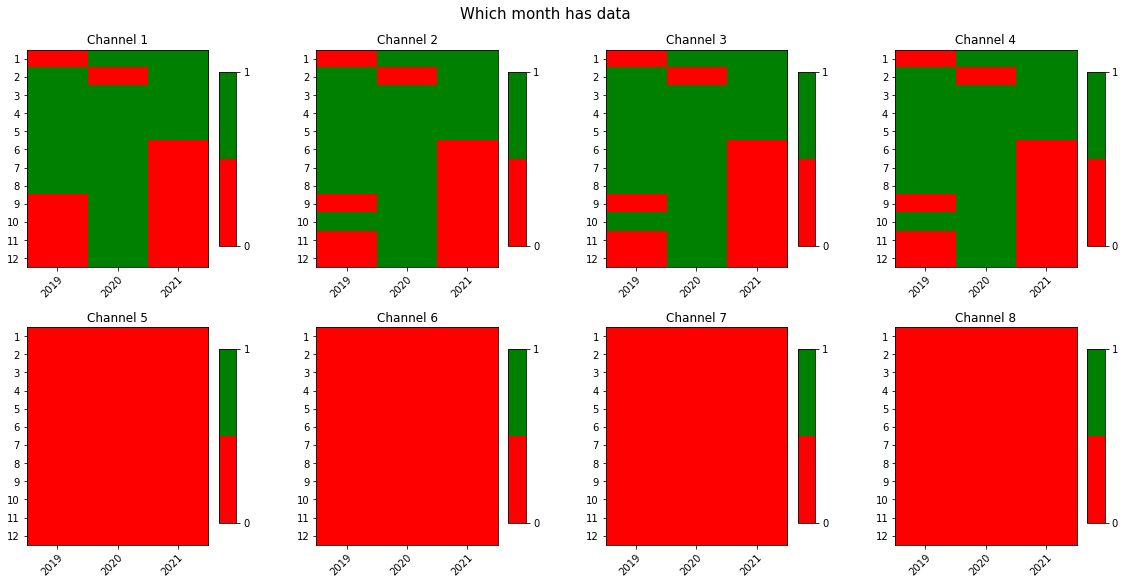

In [11]:
# alter Plot
# does not contain daniel data
# improvements: add df_unique_days_month_2019 numbers to plot
# besser anderen Graphen, x-Achse Zeit; y-Achse Messungen prt Tag --> 

# Avaible Data Overview
# 1: there was a file
# 0: there was no file

fig, axes = plt.subplots(2,4,figsize=[16,8],constrained_layout=True)
fig.suptitle("Which month has data", fontsize=15)
cmap = colors.ListedColormap(['red', 'green'])
#norm = colors.Normalize(vmin=0, vmax=1)
channel_plot=0
for ax in axes.flat:
    channel_plot+=1
    im = ax.imshow(data_for_month_avaible[channel_plot].to_numpy(dtype=int), cmap=cmap, aspect=0.3,vmin=0,vmax=1)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["2019","2020","2021"])
    ax.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_title(f"Channel {channel_plot}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    cbar = ax.figure.colorbar(im,ax=ax,shrink=0.8,ticks=[0,1])

#axes[1, 3].remove()  # don't display empty ax
#fig.tight_layout()
plt.show()

In [12]:
# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in th new dictionaries

def improve_n_meas_pday(n_meas_pday, year):
    """returns a dic, which also has days with 0 measurements"""
    improved_n_meas_pday=defaultdict(dict)
    channelnumbers=["1","2","3","4","5","6","7","8"]
    for c in channelnumbers: # loop over each channel
        for day in all_days_of_year(year):
            if day in n_meas_pday[c].keys():
                improved_n_meas_pday[c][day] = n_meas_pday[c][day]
            else:
                improved_n_meas_pday[c][day] = 0
    return improved_n_meas_pday

#n_meas_pday_2018_with0=improve_n_meas_pday(n_meas_pday_2018, 2018)
n_meas_pday_2019_with0=improve_n_meas_pday(n_meas_pday_2019, 2019)
n_meas_pday_2020_with0=improve_n_meas_pday(n_meas_pday_2020, 2020)
n_meas_pday_2021_with0=improve_n_meas_pday(n_meas_pday_2021, 2021)

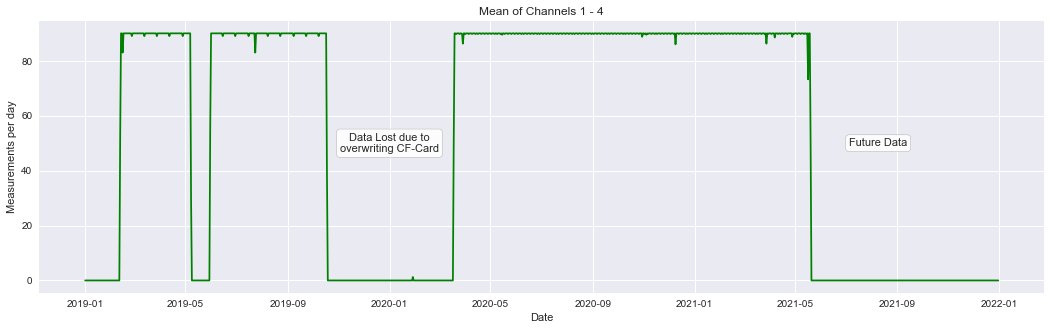

In [13]:
#Plot mean measurements per channel
def calc_mean_channels_n_pday(n_meas_pday_20xx_with0):
    """calculate the number of measurements as mean over the 4 channels"""
    val_ch1=np.array(list(n_meas_pday_20xx_with0["1"].values()))
    val_ch2=np.array(list(n_meas_pday_20xx_with0["2"].values()))
    val_ch3=np.array(list(n_meas_pday_20xx_with0["3"].values()))
    val_ch4=np.array(list(n_meas_pday_20xx_with0["4"].values()))
    mean=(val_ch1+val_ch2+val_ch3+val_ch4)/4

    # check if dates are equal
    date_ch1=pd.to_datetime(list(n_meas_pday_20xx_with0["1"]))
    date_ch2=pd.to_datetime(list(n_meas_pday_20xx_with0["2"]))
    date_ch3=pd.to_datetime(list(n_meas_pday_20xx_with0["3"]))
    date_ch4=pd.to_datetime(list(n_meas_pday_20xx_with0["4"]))
    counter_equal=0
    counter_not_equal=0
    for i in range(len(date_ch1)):
        if date_ch1[i] == date_ch2[i] and date_ch3[i] and date_ch4[i]:
            #print("all dates for mean calculation are equal")
            counter_equal+=1
    else:
        #print("dates for mean calculation are not equal!")
        #print(date_ch1[i]);print(date_ch2[i]);print(date_ch3[i]);print(date_ch4[i])
        counter_not_equal+=1
    if counter_not_equal >= 3: # 31.12. seems to be a problem? Dont know why. Not very important.
        print("check dates")
    return mean, date_ch1

#mean_2018, date_2018 = calc_mean_channels_n_pday(n_meas_pday_2018_with0)
mean_2019, date_2019 = calc_mean_channels_n_pday(n_meas_pday_2019_with0)
mean_2020, date_2020 = calc_mean_channels_n_pday(n_meas_pday_2020_with0)
mean_2021, date_2021 = calc_mean_channels_n_pday(n_meas_pday_2021_with0)

plt.style.use("seaborn")
plt.figure(figsize=[18,5])
#plt.plot(date_2018, mean_2018,color="green")
plt.plot(date_2019, mean_2019,color="green")
plt.plot(date_2020, mean_2020,color="green")
plt.plot(date_2021, mean_2021,color="green")
plt.ylabel("Measurements per day")
plt.xlabel("Date")
plt.title(f"Mean of Channels 1 - 4")

# PLOT ACCESSOIREs, Plot Patches with description
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
plt.text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# p is index of last date with 0 data from behind
p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=80)))
plt.text(x, y,"Future Data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box

if plot_save:
    plt.savefig("pictures/mean_of_all_channels_measpday.png")
    plt.savefig("pictures/dpi720/mean_of_all_channels_measpday_dpi720.png", dpi=720)
plt.show()

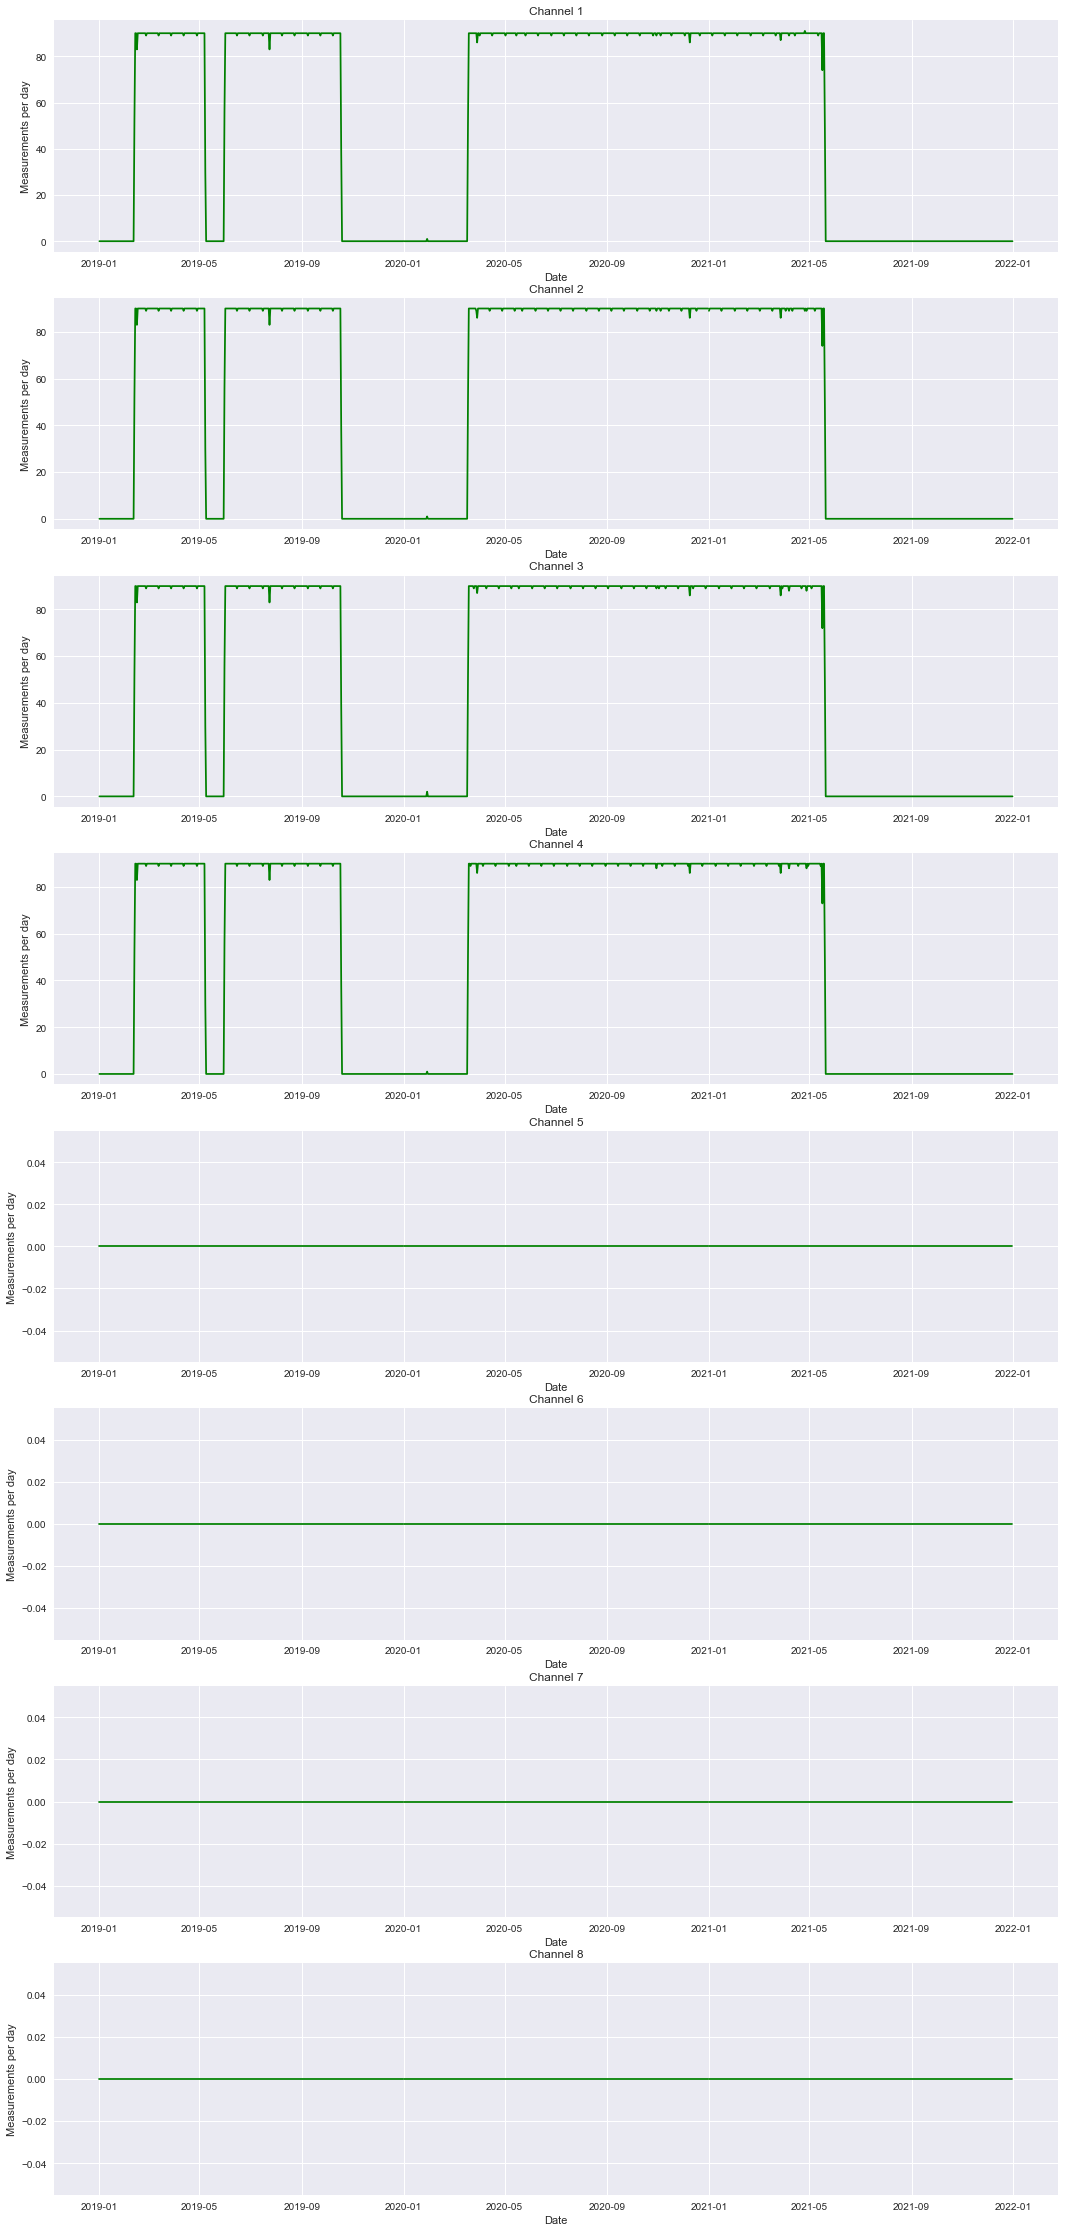

In [14]:
# Plot each channel seperate
#from cycler import cycler

plt.style.use("seaborn")
# when plotting all different channels in one plot using a loop, this cycler is handy
#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['--', '--', '--', '--'])))
fig,axs=plt.subplots(8,1,figsize=[18,40])
for channel in ["1","2","3","4","5","6","7","8"]:
    n=int(channel)-1
    c="green"
    #axs[n].plot(pd.to_datetime(list(n_meas_pday_2018_with0[channel])), n_meas_pday_2018_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2019_with0[channel])), n_meas_pday_2019_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2020_with0[channel])), n_meas_pday_2020_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2021_with0[channel])), n_meas_pday_2021_with0[channel].values(),color=c)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")
#axs.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) + cycler('lw', [1, 2, 3, 4]))

if plot_save:
    plt.savefig("pictures/all_channels_measpday.png")
    plt.savefig("pictures/dpi720/all_channels_measpday_dpi720.png", dpi=720)
plt.show()
# part which was overwritten, 2019-09 till 2020-01, in sciebo are data till 2019-10.

# 90 Messungen pr Tag pro Channel is maximum: 24*60*60/90/4 = 240 s Mittelungszeitraum einer Messung
# 24*60*60: Sekunden pro Tag
# 90: Messungen pro Tag
# 4: Channel in denen gemessen wird

In [15]:
# To do

# adjust everything, so that it works for channel 1 to 8, because the new data will be also in the channels 5,6,7,8
#   in mean meas per day bereiche markieren und patch hinzufügen indem steht wann EGRT Kabel angeschlossen wurde

# divide notebook into two
#   one which only imports and saves data
#   another one which analyses (plots) the data
#   atleast create a seperate script for plotting, maybe also keep some plots in the import script
#   maybe 2018 data seperate notebook too


# To-Do
# Im Plot am Ende genaues Datum markieren, ab dem es kaum Daten gibt

In [ ]:
last_meas_2021 = 

In [27]:
last_month=list(data_2021["1"].keys())[-1]
last_measurement_2021 = data_2021["1"][last_month].index[-1]
last_measurement_2021

Timestamp('2021-05-20 13:14:44')